# CNN on MNIST – MecaNano Summer School Tutorial
**Objective**: Train a Convolutional Neural Network (CNN) on the MNIST dataset to recognize handwritten digits. The notebook includes training, validation, performance visualization, and prediction on user-provided images.

In [11]:
# ====================================
# IMPORT LIBRARIES
# ====================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import os

In [12]:
# ====================================
# SET HYPERPARAMETERS AND LOAD DATA
# ====================================
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Standard transform for validation and test
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST(root='../data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='../data', train=False, download=False, transform=transform)

num_train = int((1 - VALIDATION_SPLIT) * len(dataset))
num_val = len(dataset) - num_train
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
# ====================================
# DEFINE CNN ARCHITECTURE
# ====================================
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [8]:
from torchviz import make_dot
import torch

# Create an instance of the model
model = CNN()

# Generate a dummy input tensor (like a single MNIST image)
sample_input = torch.randn(1, 1, 28, 28)

# Perform a forward pass to get the output
output = model(sample_input)

# Visualize the model's computational graph
make_dot(output, params=dict(model.named_parameters()))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [14]:
# ====================================
# TRAINING LOOP
# ====================================
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    correct = 0
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    val_loss /= len(val_loader)
    val_acc = correct / len(val_dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

Epoch 1: Train Loss=0.2034, Val Loss=0.0534, Val Acc=0.9847
Epoch 2: Train Loss=0.0884, Val Loss=0.0497, Val Acc=0.9868
Epoch 3: Train Loss=0.0694, Val Loss=0.0417, Val Acc=0.9885
Epoch 4: Train Loss=0.0562, Val Loss=0.0372, Val Acc=0.9893
Epoch 5: Train Loss=0.0481, Val Loss=0.0396, Val Acc=0.9887
Epoch 6: Train Loss=0.0428, Val Loss=0.0342, Val Acc=0.9892
Epoch 7: Train Loss=0.0395, Val Loss=0.0341, Val Acc=0.9897
Epoch 8: Train Loss=0.0339, Val Loss=0.0362, Val Acc=0.9903
Epoch 9: Train Loss=0.0327, Val Loss=0.0326, Val Acc=0.9898
Epoch 10: Train Loss=0.0286, Val Loss=0.0330, Val Acc=0.9912


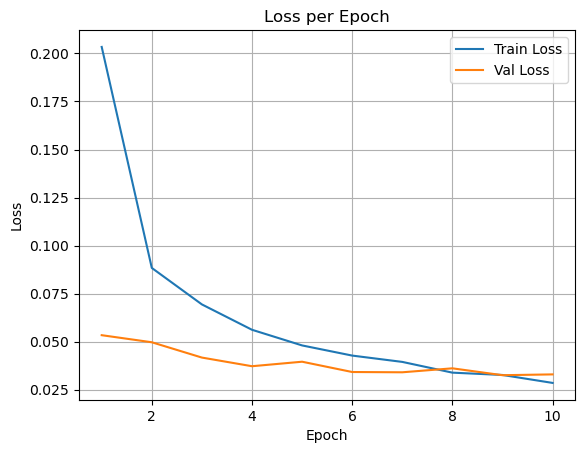

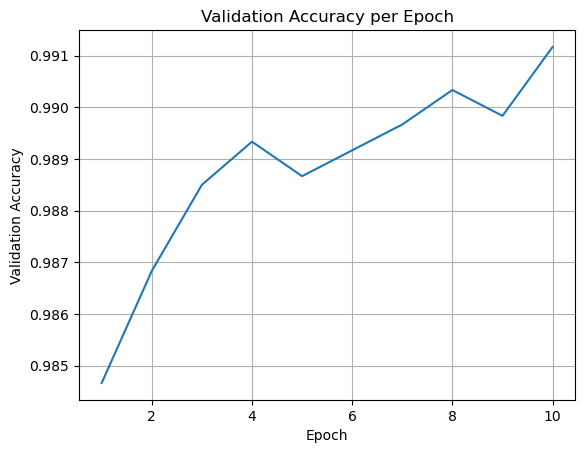

In [15]:
# ====================================
# PLOT LOSS AND ACCURACY
# ====================================
plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, EPOCHS+1), val_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.grid(True)
plt.show()

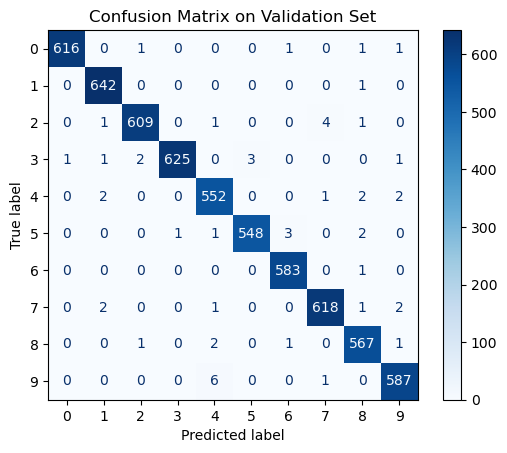

In [16]:
# ====================================
# CONFUSION MATRIX
# ====================================
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for data, target in val_loader:
        data = data.to(device)
        output = model(data)
        preds = output.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(target.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Validation Set")
plt.show()

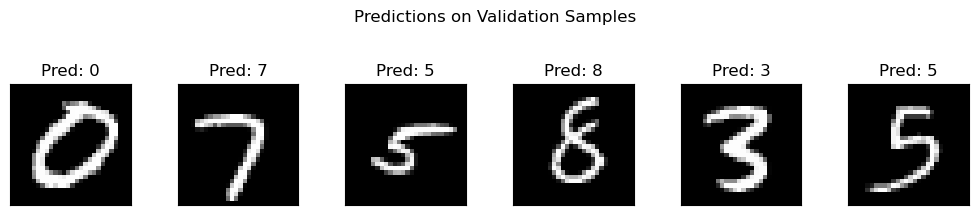

In [17]:
# ====================================
# EXAMPLE PREDICTIONS
# ====================================
examples = enumerate(val_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data = example_data.to(device)

with torch.no_grad():
    output = model(example_data)

preds = output.argmax(dim=1)

plt.figure(figsize=(10, 3))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')
    plt.title(f"Pred: {preds[i].item()}")
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Predictions on Validation Samples")
plt.show()

In [ ]:
# ====================================
# USER IMAGE PREDICTION
# ====================================
def predict_custom_image(image_path):
    img = Image.open(image_path).convert('L').resize((28, 28))
    img = transforms.ToTensor()(img)
    img = transforms.Normalize((0.1307,), (0.3081,))(img)
    img = img.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    return pred

# Example usage:
# print(predict_custom_image("user_digit.png"))